#Exploring Data

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB      # For continuous features
from sklearn.naive_bayes import MultinomialNB   # For count data (e.g. text)
from sklearn.naive_bayes import BernoulliNB     # For binary/boolean features
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.stats import loguniform, randint

#To Import BayesSearch
# !pip install scikit-optimize
# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer

train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [ ]:
train_df.isna().sum().sort_values(ascending=False)

,0
CryoSleep,217
ShoppingMall,208
VIP,203
HomePlanet,201
Name,200
Cabin,199
VRDeck,188
Spa,183
FoodCourt,183
Destination,182


In [ ]:
train_df.duplicated().sum()

np.int64(0)

#Preprocessing Data

In [ ]:
def split_cabin(df):
    df[['Cabin_Deck', 'Cabin_Num', 'Cabin_Side']] = df['Cabin'].str.split('/', expand=True)
    return df.drop(columns=['Cabin'])

train_df = split_cabin(train_df)
test_df = split_cabin(test_df)

spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [ ]:
#Handling Missing Values

for col in ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_Deck', 'Cabin_Side']:
    mode = train_df[col].mode()[0]
    train_df[col].fillna(mode, inplace=True)
    test_df[col].fillna(mode, inplace=True)

for col in ['Age'] + spending_cols :
    median = train_df[col].median()
    train_df[col].fillna(median, inplace=True)
    test_df[col].fillna(median, inplace=True)

In [ ]:
#Drop Irrelevant Features

train_df.drop(columns=['Name', 'PassengerId', 'Cabin_Num'], inplace=True)
test_passenger_ids = test_df['PassengerId']  # save for final prediction
test_df.drop(columns=['Name', 'PassengerId', 'Cabin_Num'], inplace=True)

In [ ]:
#Handling Outliers

for col in spending_cols:
    cap = train_df[col].quantile(0.99)
    train_df[col] = train_df[col].clip(upper=cap)
    test_df[col] = test_df[col].clip(upper=cap)

In [ ]:
#Feature Engineering

train_df['Total_Spending'] = train_df[spending_cols].sum(axis=1)
test_df['Total_Spending'] = test_df[spending_cols].sum(axis=1)

train_df['Spending_per_Age'] = train_df['Total_Spending'] / (train_df['Age'] + 1)
test_df['Spending_per_Age'] = test_df['Total_Spending'] / (test_df['Age'] + 1)

train_df['NoSpendingWhileCryo'] = ((train_df['CryoSleep'] == True) & (train_df['Total_Spending'] == 0)).astype(int)
test_df['NoSpendingWhileCryo'] = ((test_df['CryoSleep'] == True) & (test_df['Total_Spending'] == 0)).astype(int)

train_df['Deck_Destination'] = train_df['Cabin_Deck'] + '_' + train_df['Destination']
test_df['Deck_Destination'] = test_df['Cabin_Deck'] + '_' + test_df['Destination']

train_df['Age_VIP'] = train_df['Age'] * train_df['VIP']
test_df['Age_VIP'] = test_df['Age'] * test_df['VIP']

train_df['Spending_Per_Age'] = train_df['Total_Spending'] / (train_df['Age'] + 1)
test_df['Spending_Per_Age'] = test_df['Total_Spending'] / (test_df['Age'] + 1)

train_df["Regular"] = train_df["FoodCourt"] + train_df["ShoppingMall"]
test_df["Regular"] = test_df["FoodCourt"] + test_df["ShoppingMall"]

train_df["Luxury"] = train_df["RoomService"] + train_df["Spa"] + train_df["VRDeck"]
test_df["Luxury"] = test_df["RoomService"] + test_df["Spa"] + test_df["VRDeck"]

In [ ]:
bool_cols = ['CryoSleep', 'VIP']
for col in bool_cols:
    train_df[col] = train_df[col].astype(bool).astype(int)
    test_df[col] = test_df[col].astype(bool).astype(int)

train_df['Transported'] = train_df['Transported'].astype(bool).astype(int)

categorical_cols = ['HomePlanet', 'Destination', 'Cabin_Deck', 'Cabin_Side', 'Deck_Destination']
train_df = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
test_df = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 49 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CryoSleep                         8693 non-null   int64  
 1   Age                               8693 non-null   float64
 2   VIP                               8693 non-null   int64  
 3   RoomService                       8693 non-null   float64
 4   FoodCourt                         8693 non-null   float64
 5   ShoppingMall                      8693 non-null   float64
 6   Spa                               8693 non-null   float64
 7   VRDeck                            8693 non-null   float64
 8   Transported                       8693 non-null   int64  
 9   Total_Spending                    8693 non-null   float64
 10  Spending_per_Age                  8693 non-null   float64
 11  NoSpendingWhileCryo               8693 non-null   int64  
 12  Age_VI

In [ ]:
for df in [train_df, test_df]:
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype(int)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 49 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CryoSleep                         8693 non-null   int64  
 1   Age                               8693 non-null   float64
 2   VIP                               8693 non-null   int64  
 3   RoomService                       8693 non-null   float64
 4   FoodCourt                         8693 non-null   float64
 5   ShoppingMall                      8693 non-null   float64
 6   Spa                               8693 non-null   float64
 7   VRDeck                            8693 non-null   float64
 8   Transported                       8693 non-null   int64  
 9   Total_Spending                    8693 non-null   float64
 10  Spending_per_Age                  8693 non-null   float64
 11  NoSpendingWhileCryo               8693 non-null   int64  
 12  Age_VI

In [ ]:
train_df.duplicated().sum()

np.int64(1936)

In [ ]:
train_df.drop_duplicates(inplace=True)
print(train_df.shape)

(6757, 49)


#Splitting Data

In [ ]:
X = train_df.drop(columns=["Transported"])
y = train_df["Transported"]

y.value_counts()

,count
Transported,
0,3950
1,2807


#Random Forest

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

Cross-validation scores: [0.77218935 0.76183432 0.77868246 0.76387861 0.75203553]
Mean CV accuracy: 0.7657240527507566


In [ ]:
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

random_search.fit(X, y)

print("\nBest Parameters from Randomized Search:")
print(random_search.best_params_)
best_model_2 = random_search.best_estimator_


Best Parameters from Randomized Search:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tuned_cv_scores = cross_val_score(best_model_2, X, y, cv=cv, scoring='accuracy')
print("\nTuned Random Forest CV Accuracy: {:.4f}".format(tuned_cv_scores.mean()))


Tuned Random Forest CV Accuracy: 0.7830


#XGBOOST

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb, X, y, cv=cv, scoring='accuracy')

# Evaluate
print("CV Accuracy Scores:", scores)
print("Mean Accuracy: %.2f%%" % (scores.mean() * 100))

CV Accuracy Scores: [0.78106509 0.77218935 0.78904515 0.78756477 0.77276092]
Mean Accuracy: 78.05%


In [ ]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=50,
    cv=cv,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X, y)

best_model = search.best_estimator_

print("Best Parameters:", search.best_params_)
print("Best CV Accuracy: %.2f%%" % (search.best_score_ * 100))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best CV Accuracy: 80.08%


#Feature Selection using Feature Importance

<Figure size 1200x600 with 0 Axes>

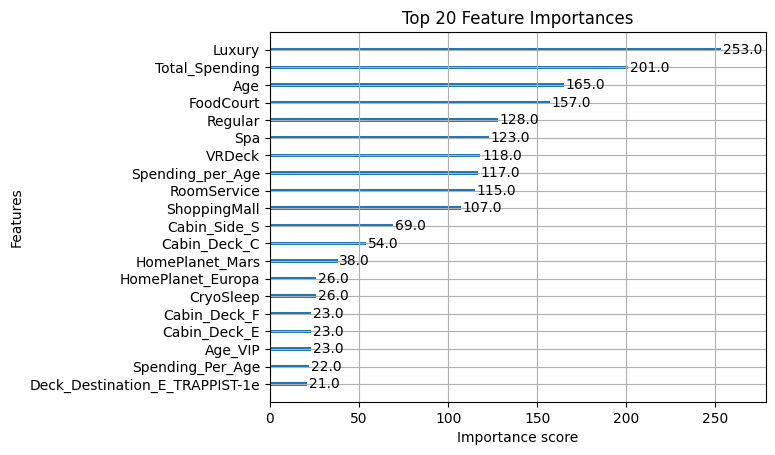

In [ ]:
#Plotting Top 20 Features

from xgboost import plot_importance

plt.figure(figsize=(12, 6))
plot_importance(best_model, max_num_features=20)
plt.title("Top 20 Feature Importances")
plt.show()

In [ ]:
#Showing least important features

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance_df.tail(10))

                             Feature  Importance
44    Deck_Destination_G_55 Cancri e    0.003248
32    Deck_Destination_C_55 Cancri e    0.003079
30  Deck_Destination_B_PSO J318.5-22    0.000000
27  Deck_Destination_A_PSO J318.5-22    0.000000
25                      Cabin_Deck_T    0.000000
33  Deck_Destination_C_PSO J318.5-22    0.000000
36  Deck_Destination_D_PSO J318.5-22    0.000000
37    Deck_Destination_D_TRAPPIST-1e    0.000000
41    Deck_Destination_F_55 Cancri e    0.000000
47    Deck_Destination_T_TRAPPIST-1e    0.000000


In [ ]:
threshold = 0.01
selected_features = importance_df[importance_df['Importance'] > threshold]['Feature'].tolist()

# Reduce train and test to selected features
X_reduced = X[selected_features]
test_df_reduced = test_df[selected_features]

In [ ]:
#Datasets Before and After

print(X.shape)
print(X_reduced.shape)
print('------------')
print(test_df.shape)
print(test_df_reduced.shape)

(6757, 48)
(6757, 25)
------------
(4277, 47)
(4277, 25)


In [ ]:
#RandomizedSearch on new dataset

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=70,
    cv=cv,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_reduced, y)

best_model_reduced = search.best_estimator_

print("Best Parameters:", search.best_params_)
print("Best CV Accuracy: %.2f%%" % (search.best_score_ * 100))

Fitting 5 folds for each of 70 candidates, totalling 350 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best CV Accuracy: 80.17%


#Prepare Submission File

In [ ]:
#For normal Datasets

test_df = test_df.reindex(columns=X.columns, fill_value=0)

y_prob = best_model.predict_proba(test_df)[:, 1]
y_pred = y_prob >= 0.5
submission_df = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Transported': y_pred.astype(bool)
})

submission_df.to_csv("submission.csv", index=False)

In [ ]:
#For Reduced Datasets

test_df_reduced = test_df_reduced.reindex(columns=X_reduced.columns, fill_value=0)

y_prob = best_model_reduced.predict_proba(test_df_reduced)[:, 1]
y_pred = y_prob >= 0.5
submission_df = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Transported': y_pred.astype(bool)
})

submission_df.to_csv("submission3.csv", index=False)

#Trails

**CatBoost**

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.9 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

# Define the base model
cat = CatBoostClassifier(
    verbose=0,
    random_state=42,
    # Add `cat_features=cat_features` only if your features include categorical raw strings or indices
)

# Define parameter grid
param_dist = {
    'iterations': [100, 300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0, 0.5, 1.0],
    'random_strength': [1, 5, 10],
}

# Random search setup
cat_random_search = RandomizedSearchCV(
    estimator=cat,
    param_distributions=param_dist,
    n_iter=70,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit on reduced training data
cat_random_search.fit(X_reduced, y)

# Get the best model
best_cat_model = cat_random_search.best_estimator_

# Output
print("Best CatBoost Params:", cat_random_search.best_params_)
print("Best CV Accuracy: %.2f%%" % (cat_random_search.best_score_ * 100))

Fitting 5 folds for each of 70 candidates, totalling 350 fits
Best CatBoost Params: {'random_strength': 10, 'learning_rate': 0.1, 'l2_leaf_reg': 9, 'iterations': 700, 'depth': 4, 'border_count': 128, 'bagging_temperature': 1.0}
Best CV Accuracy: 80.11%


**Combining XgBoost with CatBoost**

In [ ]:
from sklearn.ensemble import VotingClassifier

# Use the best-tuned models
xgb_best = search.best_estimator_
cat_best = cat_random_search.best_estimator_

voting_clf = VotingClassifier(
    estimators=[('xgb', xgb_best), ('cat', cat_best)],
    voting='soft',  # soft = average probabilities
    n_jobs=-1
)

voting_clf.fit(X_reduced, y)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(voting_clf, X_reduced, y, cv=5, scoring='accuracy')
print("Voting Classifier CV Accuracy: %.2f%%" % (scores.mean() * 100))

Voting Classifier CV Accuracy: 79.89%


In [ ]:
from sklearn.ensemble import StackingClassifier

# Base learners
estimators = [
    ('xgb', xgb_best),
    ('cat', cat_best)
]

# Meta-model
final_estimator = LogisticRegression(max_iter=1000, random_state=42)

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,  # or your preferred cv value
    n_jobs=-1,
    passthrough=False  # Set to True if you want original features added to meta-model
)

stacking_clf.fit(X_reduced, y)

# Cross-validation accuracy
cv_scores = cross_val_score(stacking_clf, X_reduced, y, cv=5, scoring='accuracy')
print(f"Stacking CV Accuracy: {cv_scores.mean():.4f}")

Stacking CV Accuracy: 0.7981


**LightGBM**

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define parameter grid
lgbm_params = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 12),
    'num_leaves': randint(20, 150),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

# Instantiate model
lgbm = LGBMClassifier(random_state=42)

# Randomized Search
lgbm_random = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=lgbm_params,
    n_iter=50,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the model
lgbm_random.fit(X, y)

# Best model
best_lgbm = lgbm_random.best_estimator_
print("Best LGBM params:", lgbm_random.best_params_)
print("Best CV Accuracy: %.2f%%" % (lgbm_random.best_score_ * 100))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2807, number of negative: 3950
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2722
[LightGBM] [Info] Number of data points in the train set: 6757, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.415421 -> initscore=-0.341599
[LightGBM] [Info] Start training from score -0.341599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li